# Optimizing an X-gate with a Gaussian square envelope

The goal of this project is to optimize the width of a GaussianSquare pulse envelope to implement an X-gate.

The notebook contains the following sections:
1. The model and Solver
2. Visualizing the Gaussian square envelope
3. Setting up JAX and parametrizing the pulse
4. Defining the objective function
5. Performing the optimization with BFGS
7. Simulating state evolution
8. Extending the task to other pulses and optimization methods

This notebook is based on the [qiskit pulse](https://github.com/qiskit-community/qiskit-dynamics/blob/main/docs/tutorials/qiskit_pulse.rst) and [pulse sequency optimization](https://github.com/qiskit-community/qiskit-dynamics/blob/main/docs/tutorials/optimizing_pulse_sequence.rst) tutorials by Qiskit.

In [35]:
# silence deprecation warnings from pulse
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)   

# 1. The model and solver

In the qiskit dynamics library, we typically simulate Hamiltonians of the form: $H = H_{static} + \sum_j s_j(t) H_{j}$, where $s_j(t)$ are the signals for the Hamiltonian operators $H_j$. The signal combines an envelope, in our case a Gaussian square, with a carrier frequency, the qubit resonance frequency. The Hamiltonian of a qubit driven by a microwave source can be written as $H = H_{qubit} + H_{drive} = \frac{2 \pi \omega_q}{2}\hat{Z} + \frac{2 \pi r}{2}s(t) \hat{X}$. Below we define this model and set system parameters.

In [36]:
import numpy as np
from qiskit.quantum_info import Operator
import numpy as np
from qiskit_dynamics import Solver

# system parameters

wq = 5.0 # qubit transition frequency (GHz)
r = 0.02 # rabi frequency (GHz)
dt = 0.222 # sampling rate for backend (ns) 
T = 230 # pulse duration (ns)

H_qubit = 2 * np.pi * wq * Operator.from_label('Z') / 2
H_drive = 2 * np.pi * r * Operator.from_label('X') / 2

Once we have defined the Hamiltonian, we can make a Solver object from it. This solver can be called when we want to integrate the Schrödinger equation to solve for time-evolution with our Gaussian square signals. We pass the qubit term as the static Hamiltonian and the drive term as the hamiltonian operator.

In [37]:

H_solver = Solver(
    hamiltonian_operators=[H_drive],
    static_hamiltonian=H_qubit,
    rotating_frame=H_qubit
)

# 2. Visualizing the GaussianSquare envelope

The GaussianSquare pulse is a square signal with smooth edges. Smoothed edges is beneficial to limit high-frequency components that are inherent to rectangular pulses due to discontinuities at pulse edges. Level of smoothness is defined by parameter sigma. Below is a visualization of the differences between the gaussian square and the square pulse defined in qiskit. In our notebook, we optimize sigma and the width of the pulse. Because higher-order energy levels are not included in the qubit Hamiltonian, the effects of high-frequency components are neglected. As a result, there is some flexibility in the choice of sigma that provide high fidelity.

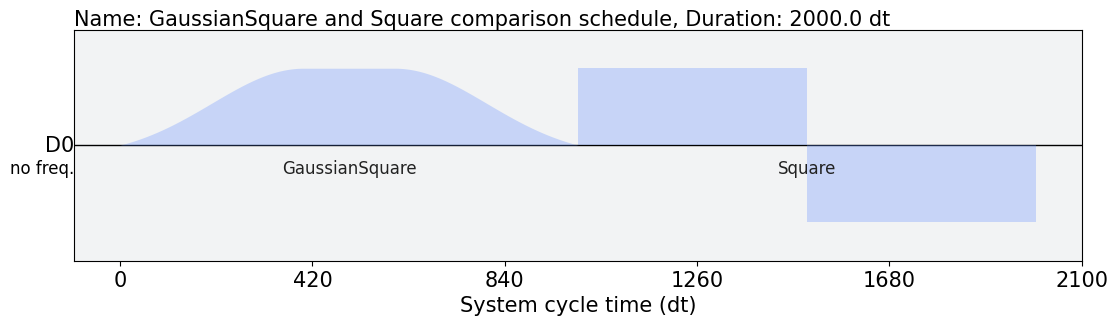

In [38]:
import qiskit.pulse as pulse

# test parameters for visualizing the envelope shape
amp = 1.0
delta = T/1000 # make time step small for visualization
duration = int(T / delta)
test_sigma = T/5
width = duration-4*test_sigma/delta # the width is 
with pulse.build(name="GaussianSquare and Square comparison schedule") as sxp:
    pulse.play(pulse.GaussianSquare(duration, amp, test_sigma / delta, width), pulse.DriveChannel(0))
    pulse.play(pulse.Square(duration, amp, phase=0), pulse.DriveChannel(0))

sxp.draw()


# 3. Setting up JAX and parametrizing the Pulse

For width optimization, we will use the Broyden-Fletcher-Goldfarb-Shanni (BFGS) method. Different numerical methods could be explored here, but the BFGS is chosen because it was used in the tutorials. The method is based on gradients, and therefore efficient gradient calculation is important. We utilize the [JAX library](https://docs.jax.dev/en/latest/), a more efficient alternative to Numpy, to make gradient calculations during optimization faster. 

In [39]:
# configure JAX
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True) 
jax.config.update('jax_platform_name', 'cpu')


Only the class ScalableSymbolicPulse is compatible with JAX, so we can not directly use the GaussianSquare class that is readily defined in qiskit. The functions below, from the [qiskit tutorial](https://github.com/qiskit-community/qiskit-dynamics/blob/main/docs/tutorials/optimizing_pulse_sequence.rst), are functions to obtain ScalableSymbolicPulse versions of the GaussianSquare pulses that are parametrized by width and sigma.

In [40]:

import sympy as sym
from qiskit import pulse

# helper function for the smoothed right and left edges of the Gaussian square pulse

def lifted_gaussian( 
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

# function for generating Gaussian square pulses parametrized by width and sigma

def gaussian_square_generated_by_pulse(params):

    width, sigma = params
    _t, _duration, _amp, _sigma, _width, _angle = sym.symbols(
        "t, duration, amp, sigma, width, angle"
    )
    _center = _duration / 2

    _sq_t0 = _center - _width / 2
    _sq_t1 = _center + _width / 2

    _gaussian_ledge = lifted_gaussian(_t, _sq_t0, -1, _sigma)
    _gaussian_redge = lifted_gaussian(_t, _sq_t1, _duration + 1, _sigma)

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * sym.Piecewise(
            (_gaussian_ledge, _t <= _sq_t0), (_gaussian_redge, _t >= _sq_t1), (1, True)
        )
    )

    pulse.ScalableSymbolicPulse.disable_validation = True # makes code compatible with JAX

    return pulse.ScalableSymbolicPulse(
            pulse_type="GaussianSquare",
            duration=T,
            amp=1,
            angle=0,
            parameters={"sigma" : sigma, "width": width},
            envelope=envelope_expr,
            constraints=sym.And(_width >= 0, _duration >= _width),
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )


# 4. Defining the objective function

## Fidelity of the pulse

When maximizing the gate fidelity $F(U) \in [0, 1]$ of the gate $U$ implemented with the GaussianSquare pulse, our objective function to be minimized is the infidelity $I(U)= 1 - F(U)$. When optimizing an X-gate, the fidelity can be computed as $F(U) = \frac{|Tr(XU)|^2}{4}$.

In [41]:
X = Operator.from_label('X').data
def fidelity(U):
    return jnp.abs(jnp.sum(X * U))**2 / 4.

In [42]:
from qiskit.circuit.library import RXGate
# perfect X gate
print("Fidelity of a perfect X gate: ", fidelity(X))

# Gate that does not perform a full pi rotation
X_noisy = RXGate(3/4*np.pi).to_matrix()
print("Fidelity of a faulty X gate: ", fidelity(X_noisy))


Fidelity of a perfect X gate:  1.0
Fidelity of a faulty X gate:  0.8535533905932737


Next we define the objective function. If our pulse implements an operator $U$, We can return the infidelity of $U$ as the objective function. We obtain $U$ by simulating the effect of our pulse on the identity operator.

In [19]:
from qiskit_dynamics.pulse import InstructionToSignals

def objective(params):
    # generating the pulse
    gaussian_square_pulse = gaussian_square_generated_by_pulse(params)

    # making pulse schedule
    with pulse.build() as Xp:
        pulse.play(gaussian_square_pulse, pulse.DriveChannel(0))

    # converting schedule to pulse signal
    converter = InstructionToSignals(dt, carriers={"d0": wq})
    signal = converter.get_signals(Xp)

    # simulating U by evolving the identity under the pulse
    result = H_solver.solve(
        y0=np.eye(2, dtype=complex),
        t_span=[0, gaussian_square_pulse.duration * dt],
        signals=[signal],
        method='jax_odeint',
        atol=1e-8,
        rtol=1e-8
    )
    # Extracting U at the end of the simulation and returning infidelity
    U = result[0].y[-1]
    return 1. - fidelity(U)

# 5. Performing the optimization with BFGS 


We use our parametrized gaussian square pulse to find the optimal width and sigma to implement an X gate. As in the tutorial, we perform optimization with the BFGS method. However, to see if there are multiple values of width that provide high fidelities, we perform the optimization `rounds` times, with different intitial values. This should reduce the probability of our procedure returning parameters from non-optimal local minima. Additionally, we save the fidelity information for one round of optimization to see how the fidelity of our pulse increases during the optimization.

In [20]:
from jax import jit, value_and_grad
from scipy.optimize import minimize

fidelity_evolution = []

# callback function for saving intermediate fidelities
def cb(x):
    fid = (1-objective(x))
    fidelity_evolution.append(fid)

jit_grad_obj = jit(value_and_grad(objective))

rounds = 5 # number of rounds we perform the optimization with different initial values
width_MAX = T # max initial width
sigma_MAX = 100

best_params = [] # saving the best parameters
lowest_infidelity = 1 
best_fidelity_evolution = [] # saving the fidelites during optimization

# perform optimization with different initial values, saving the best one
for i in range(rounds):
    fidelity_evolution = []
    random_initial_params = np.array([np.random.random()*width_MAX, np.random.random()*sigma_MAX])
    opt_results = minimize(fun=jit_grad_obj, x0=random_initial_params, jac=True, method='BFGS', callback=cb)
    print("Optimization ", i+1, f": optimized width = ", opt_results.x[0], f"(initial width = {random_initial_params[0]}), optimized sigma = ", opt_results.x[1], f"(initial sigma = {random_initial_params[1]}" )
    
    if i == 0:
        best_params = opt_results.x
        lowest_infidelity = opt_results.fun
        best_fidelity_evolution = fidelity_evolution
    else:
        if opt_results.fun < lowest_infidelity:
            best_params = opt_results.x
            lowest_infidelity = opt_results.fun
            best_fidelity_evolution = fidelity_evolution


print("-"*100)
print(f"Final optimized width is {best_params[0]} for {T}ns GaussianSquare pulse with optimized sigma = {best_params[1]}")
print('Fidelity of gate: ' + str((1 - lowest_infidelity)*100.0), "%")

Optimization  1 : optimized width =  211.71265849921306 (initial width = 156.1640031984031), optimized sigma =  75.47746294099643 (initial sigma = 72.53716235838739
Optimization  2 : optimized width =  212.2358235127929 (initial width = 217.50613563047534), optimized sigma =  78.53084218472569 (initial sigma = 78.53238346287111
Optimization  3 : optimized width =  181.54084737407334 (initial width = 181.54084737407334), optimized sigma =  76.34294831949046 (initial sigma = 76.34294831949046
Optimization  4 : optimized width =  211.59586622207814 (initial width = 7.221957220126763), optimized sigma =  292.21497965982735 (initial sigma = 63.246549884742684
Optimization  5 : optimized width =  211.68866494378895 (initial width = 111.05565464710546), optimized sigma =  90.96306889864691 (initial sigma = 66.57117186829204
----------------------------------------------------------------------------------------------------
Final optimized width is 212.2358235127929 for 230ns GaussianSquare pu

The results suggest an optimal pulse width of approximately 212 dt, as many optimization rounds converge to this value, while sigma varies widely. Including higher energy levels would likely increase the sensitivity to sigma and could lead to a preferred value. Below, we show the fidelity improvement across iterations for the round that resulted in the highest-fidelity.

Text(0, 0.5, 'Fidelity')

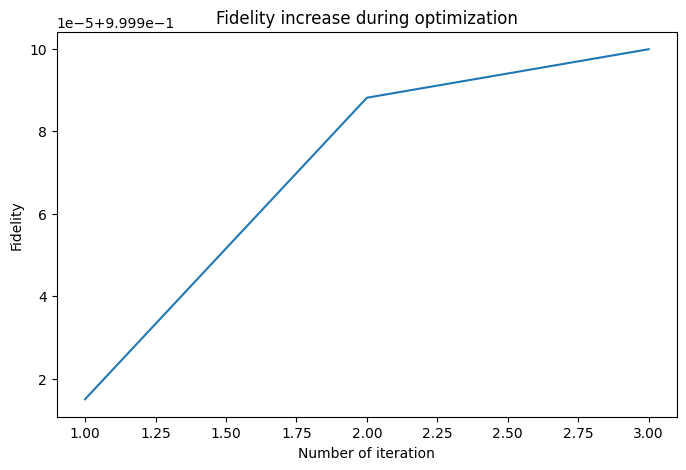

In [21]:
import matplotlib.pyplot as plt
iterations = np.linspace(1, len(best_fidelity_evolution), len(best_fidelity_evolution))
plt.figure(figsize=(8, 5))
plt.plot(iterations, best_fidelity_evolution)
plt.title("Fidelity increase during optimization")
plt.xlabel("Number of iteration")
plt.ylabel("Fidelity")

GaussianSquare(duration=230, sigma=78.53084218472569, width=212.2358235127929, amp=1, angle=0)


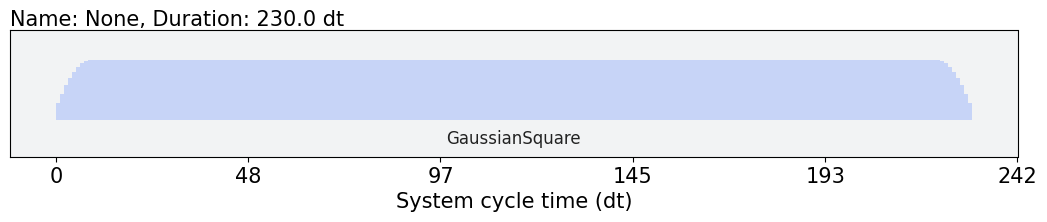

In [22]:
# Plotting the envelope with optimal width
optimized_gaussian_square = gaussian_square_generated_by_pulse(best_params)
print(optimized_gaussian_square)
optimized_gaussian_square.draw()

# 6. Simulating state evolution

Starting from the ground state, we can now simulate how to state evolves when we apply the optimized gaussian square pulse. Based on the fidelity of the gate (> 99.99%) obtained from the optimization procedure, we expect an almost full transition from |0> to |1>.

In [23]:
from qiskit.quantum_info.states import Statevector

# creating pulse schedule 
with pulse.build() as Xp:
    pulse.play(optimized_gaussian_square, pulse.DriveChannel(0))

# converting schedule to signal
converter = InstructionToSignals(dt, carriers={"d0": wq})
optimized_signal = converter.get_signals(Xp)

# simulating the effect of the pulse on the |0> state
y0 = Statevector([1., 0.])
sol = H_solver.solve(t_span=[0., T], y0=y0, signals=optimized_signal, atol=1e-8, rtol=1e-8)


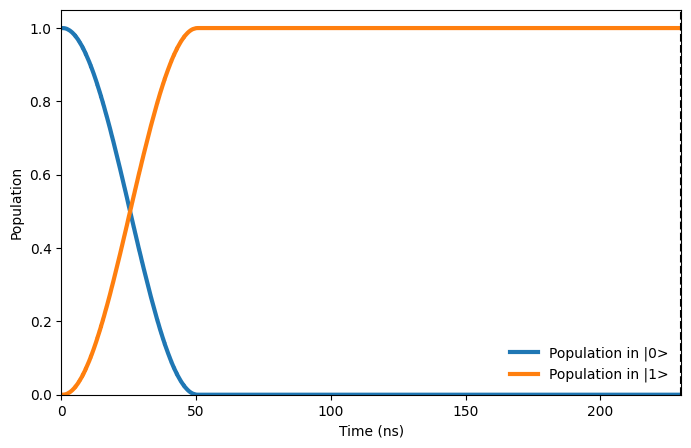

In [24]:
# Function for plotting population transfer (from pulse tutorial)
def plot_populations(sol):
        pop0 = [psi.probabilities()[0] for psi in sol.y]
        pop1 = [psi.probabilities()[1] for psi in sol.y]

        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
        plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, T])
        plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

#plotting the population of qubit under drive
plot_populations(sol)

# 7. Extending the task to other pulses and methods

Now we generalize the task by defining a function that takes as input a `ScalableSymbolicPulse` generating function and an upper bound on the parameters to be optimized. Optionally, the number of optimization rounds (default is 1) and the optimization method (default is BFGS) can be specified. The function follows the same procedure used in parts (4–5) for the GaussianSquare pulse.

In [25]:
def optimize_pulse(pulse_generator: callable, max_params: list, rounds=1, method="BFGS"):

    def objective_function(params):
        pulse_instance = pulse_generator(params)
        with pulse.build() as Xp:
            pulse.play(pulse_instance, pulse.DriveChannel(0))
        converter = InstructionToSignals(dt, carriers={"d0": wq})
        signal = converter.get_signals(Xp)
        result = H_solver.solve(
            y0=np.eye(2, dtype=complex),
            t_span=[0, pulse_instance.duration * dt],
            signals=[signal],
            method='jax_odeint',
            atol=1e-8,
            rtol=1e-8
        )
        U = result[0].y[-1]
        return 1. - fidelity(U)

    jit_grad_obj = jit(value_and_grad(objective_function))

    best_params = [] # saving the best parameters
    lowest_infidelity = 1 

    for i in range(rounds):
        random_initial_params = np.array([np.random.random()*max_params[i] for i in range(len(max_params))])
        opt_results = minimize(fun=jit_grad_obj, x0=random_initial_params, jac=True, method=method)
        print("Optimization ", i+1, f": optimized parameters = ", opt_results.x, f"(initial parameters = {random_initial_params})" )
        
        if i == 0:
            best_params = opt_results.x
            lowest_infidelity = opt_results.fun
        else:
            if opt_results.fun < lowest_infidelity:
                best_params = opt_results.x
                lowest_infidelity = opt_results.fun
    print("Final fidelity: ", str(1-lowest_infidelity/100), "%")
    return best_params
        


Optimization  1 : optimized parameters =  [212.20765201 249.97955934] (initial parameters = [113.57991029   3.0563268 ])
Optimization  2 : optimized parameters =  [211.64482946  87.56201596] (initial parameters = [177.53737391   8.53508381])
Optimization  3 : optimized parameters =  [212.05241943 151.38881773] (initial parameters = [150.56152268   1.02202847])
Final fidelity:  0.9999999983719441 %


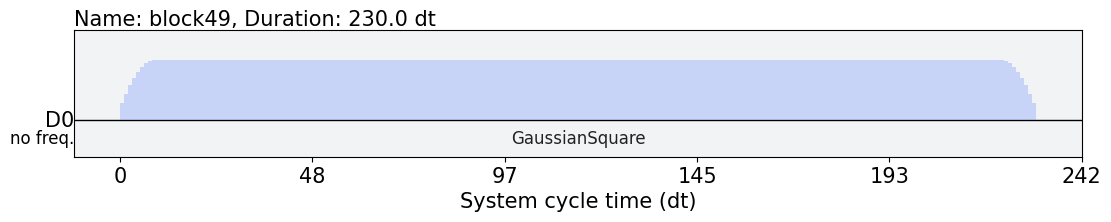

In [33]:
# Testing the function with the same GaussianSquare as before
opt_params = optimize_pulse(gaussian_square_generated_by_pulse, [T, 10], rounds=3, method="BFGS")
instance = gaussian_square_generated_by_pulse(opt_params)
with pulse.build() as b:
    pulse.play(instance, pulse.DriveChannel(0))
b.draw()

/var/folders/vg/1pzszhl968x_227h3l484y5h0000gn/T/ipykernel_63999/4084029345.py:27: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  opt_results = minimize(fun=jit_grad_obj, x0=random_initial_params, jac=True, method=method)


Optimization  1 : optimized parameters =  [69.75762632  1.79320961] (initial parameters = [69.75762632  1.79320961])
Optimization  2 : optimized parameters =  [213.60395433  10.52833459] (initial parameters = [175.96705858   9.87032294])
Optimization  3 : optimized parameters =  [218.6497019    2.90075743] (initial parameters = [138.23536568   2.64234862])
Final fidelity:  0.9999999988393061 %


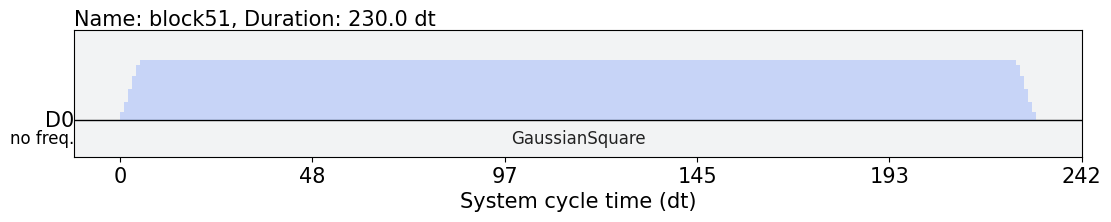

In [34]:
# Same but with the Nelder-Mead method instead.
opt_params = optimize_pulse(gaussian_square_generated_by_pulse, [T, 10], rounds=3, method="Nelder-Mead")
instance = gaussian_square_generated_by_pulse(opt_params)
with pulse.build() as b:
    pulse.play(instance, pulse.DriveChannel(0))
b.draw()

We can now use this function to optimize other pulse envelopes. This only requires a parametrized `ScalableSymbolicPulse` version of the desired pulse type. Below, we define a raised cosine generating function to optimize the envelope width and beta parameters.


In [31]:
def raised_cosine_generated_by_pulse(params):
    width, beta = params
    _t, _duration, _amp, _beta, _width, _angle = sym.symbols(
        "t, duration, amp, beta, width, angle"
    )

    _center = _duration / 2
    t_relative = _t - _center

    _left_edge = _center - _width / 2
    _right_edge = _center + _width / 2

    def sinc(x):
        return sym.sin(sym.pi*x)/(sym.pi*x)
    
    term1 = 1/(_width/2)*sinc(t_relative / (_width/2))
    term2 = sym.cos(sym.pi * _beta * t_relative / (_width/2))
    term3 = 1 - (2 * _beta * t_relative / (_width/2))**2

    _raised_cosine_window = (term1 * (term2 / term3))

    envelope_expr = (
        _amp
        * sym.exp(sym.I * _angle)
        * sym.Piecewise(
            (_raised_cosine_window, (_t >= _left_edge) & (_t <= _right_edge)),
            (0, True)
        )
    )

    pulse.ScalableSymbolicPulse.disable_validation = True

    return pulse.ScalableSymbolicPulse(
        pulse_type="raised_cosine",
        duration=T,
        amp=1,
        angle=0,
        parameters={"beta": beta, "width": width},
        envelope=envelope_expr,
        constraints=sym.And(_width >= 0, _duration >= _width, _beta >= 0, _beta <= 1),
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

We can optimize this function in the same manner as the GaussianSquare. If optimization fails and does not produce a high-fidelity pulse, the optimization can be repeated with increased number of rounds.

/var/folders/vg/1pzszhl968x_227h3l484y5h0000gn/T/ipykernel_63999/4084029345.py:27: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  opt_results = minimize(fun=jit_grad_obj, x0=random_initial_params, jac=True, method=method)


Optimization  1 : optimized parameters =  [99.26478591  0.9786919 ] (initial parameters = [99.26478591  0.9786919 ])
Optimization  2 : optimized parameters =  [116.9412398    0.54695999] (initial parameters = [116.9412398    0.54695999])
Optimization  3 : optimized parameters =  [3.65230372 0.57967969] (initial parameters = [3.65230372 0.57967969])
Optimization  4 : optimized parameters =  [29.39816604  0.13221543] (initial parameters = [29.39816604  0.13221543])
Optimization  5 : optimized parameters =  [106.67989322   0.90273293] (initial parameters = [106.67989322   0.90273293])
Final fidelity:  0.99 %


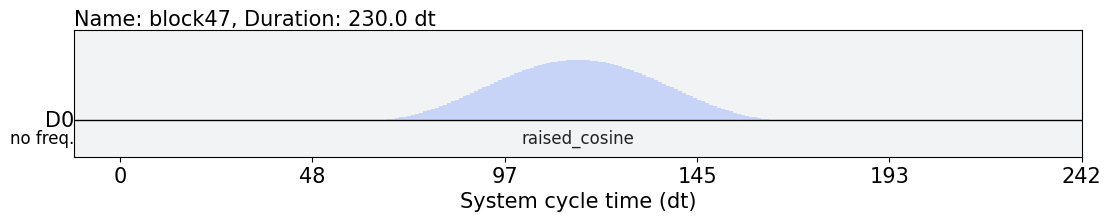

In [32]:
opt_params = optimize_pulse(raised_cosine_generated_by_pulse, [T, 1], rounds=5, method="Nelder-Mead")
instance = raised_cosine_generated_by_pulse(opt_params)
with pulse.build() as b:
    pulse.play(instance, pulse.DriveChannel(0))
b.draw()
